In [130]:
# Basic imports for data analysis and visualization:
# - numpy: numerical operations
# - pandas: dataframes and data manipulation
# - matplotlib & seaborn: plotting and visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [131]:
# Load the dataset into a pandas DataFrame from a CSV file
# Make sure the CSV file is in the same folder as this notebook or provide a full path
df = pd.read_csv("CarPriceAssignment.csv")

In [132]:
# Quick data inspection steps for beginners:
# - df.head(): view the first few rows
# - df.info(): check column types and missing values
# - df.describe(): get summary statistics for numeric columns

# These help you understand the shape and contents of the data before cleaning
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [ ]:
# Remove rows with missing values to simplify the downstream analysis.
df = df.dropna()      

In [135]:
# Drop the `car_ID` column because it is just an identifier and not a useful predictor for price
# Identifiers should generally be removed before modeling
df = df.drop(columns=['car_ID'])

In [136]:
# Create a log-transformed price column to reduce skew and stabilize variance.
# Log transformation is common for price prediction tasks.
df['price_log'] = np.log(df['price'])

# Why We Take Log of Price

##  Problem with Raw Price

Looking at dataset:

- `price` ranges from ~5,000 to ~45,000
- Distribution is **right-skewed** (most cars are cheap, few are expensive)
- Linear regression assumes a roughly **linear relationship** and **homoscedasticity** (errors have roughly constant variance)

If we train on raw `price`:

- Large prices dominate the model → regression line is pulled toward expensive cars
- Variance of errors increases with price → **heteroscedasticity**
- RMSE/MSE becomes huge → hard to interpret


In [152]:
# Remove duplicate rows from the dataset to avoid biased training results
df = df.drop_duplicates()

In [153]:
# Convert categorical variables into numeric dummy variables (one-hot encoding).
# drop_first=True prevents multicollinearity by dropping one level for each categorical feature.
df = pd.get_dummies(df, drop_first=True)

In [154]:
# Print column names so you can see the features created after encoding and cleaning
print(df.columns)

Index(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       ...
       'cylindernumber_three', 'cylindernumber_twelve', 'cylindernumber_two',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mfi', 'fuelsystem_mpfi', 'fuelsystem_spdi',
       'fuelsystem_spfi'],
      dtype='object', length=191)


In [155]:
# Work with only numeric columns to compute statistics and detect outliers.
# Drop the original `price` and `price_log` from numeric_df because we will use `price_log` as the target later.
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df = numeric_df.drop(columns=['price', 'price_log'])

In [156]:
# Calculate the first and third quartiles and IQR for each numeric column.
# These values are used to detect outliers using the IQR method.
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1


In [157]:
# Create a boolean mask that is True for rows that are NOT outliers in any numeric column
# We consider a value an outlier if it's below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
mask = ~(
    (numeric_df < (Q1 - 1.5 * IQR)) |
    (numeric_df > (Q3 + 1.5 * IQR))
).any(axis=1)

# Apply the mask to remove outlier rows from the main dataframe
df = df[mask]


In [158]:
# Check the data types of numeric columns to ensure they are numerical (int/float)
# This is useful before performing numeric operations or feeding data to models
numeric_df.dtypes

symboling             int64
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginesize            int64
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
dtype: object

In [159]:
# Select features (X) to use for prediction and the target variable (y).
# These features were chosen as examples; you can add or remove based on domain knowledge.
X = df[['wheelbase', 'carlength', 'carwidth', 'carheight',
        'curbweight', 'enginesize', 'horsepower',
        'citympg', 'highwaympg']]

# Use log-transformed price as the target to improve model behavior for skewed price data.
# Note: `df['price_log']` exists and is equivalent to np.log(df['price']).
y = np.log(df['price'])

<Axes: xlabel='wheelbase', ylabel='price'>

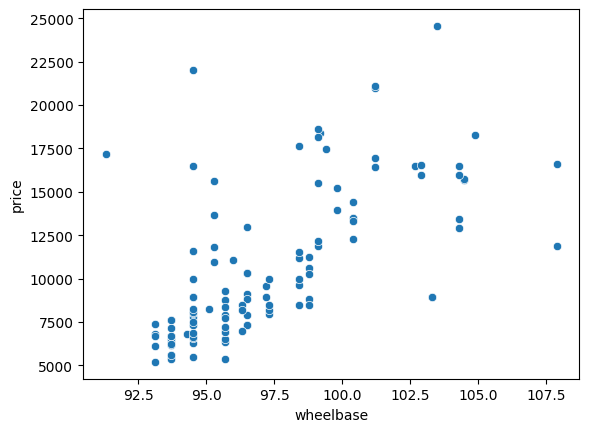

In [160]:
# Visualize the relationship between wheelbase and price to spot trends and outliers
# Scatter plots are a simple way to inspect pairwise relationships
sns.scatterplot(x=df['wheelbase'], y=df['price'])

In [161]:
# Split dataset into training and testing sets to evaluate model performance on unseen data
# test_size=0.2 means 20% of the data will be held out for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [162]:
# Standardize features so that each has mean=0 and std=1.
# Scaling is important for models that are sensitive to feature scales (like regularized regression).
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [163]:
# Fit a Ridge regression model (linear regression with L2 penalty) to prevent overfitting
from sklearn.linear_model import Ridge

# alpha controls regularization strength; higher alpha = more regularization
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [164]:
# Inspect the learned model parameters:
# - intercept: the predicted value when all features are zero
# - coefficients: the effect size of each feature on the log(price)
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: 9.196734722654972
Coefficients: [ 0.06274666  0.00413357  0.00608151 -0.02527455  0.1194168  -0.01595855
  0.12433967 -0.1966799   0.11189117]


In [165]:
# Make predictions on the scaled test set using the trained model
y_pred = model.predict(X_test_scaled)

In [166]:
# Evaluate predictions using common regression metrics:
# - RMSE: root mean squared error (lower is better)
# - MAE: mean absolute error (average absolute error)
# - R²: proportion of variance explained (closer to 1 is better)
from sklearn.metrics import  r2_score, mean_absolute_error,root_mean_squared_error

rmse  = root_mean_squared_error(y_test ,y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

RMSE: 0.15106741035353916
MAE: 0.11658010518250077
R²: 0.8048195273191108
